# Project 3
The initial exploratory data analysis (EDA) of the em-dat data set can be viewed in Countries_Eda.ipynb.
Further analysis and testing of this data set can be seen in Eda_and_Testing.ipynb.
Finally, EDA on NASA's temperature anomaly data can be seen in tempAnomalyEda.ipynb.

In this notebook, I will combine the disaster data from em-dat with the temperature anomaly data from NASA. I will train both a neural net (using pytorch) and an ensemble (tree) model (using XGBoost) to attempt predictions on future costs due to climate related natural disasters.

## Solution

Set up data holder class:

In [110]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import namedtuple

class data_holder():
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.df = self.data.copy()

    def filter_columns(self, columns_to_keep):
        self.data = self.data[columns_to_keep]

    def remove_rows_where_null(self, remove_null_rows_in_column):
        self.data = self.data.dropna(subset = remove_null_rows_in_column)

    def replace_nan_with_zero(self, replace_nan_in_columns):
        self.data[replace_nan_in_columns] = self.data[replace_nan_in_columns].fillna(0)

    def filter_values(self, column, values):
        self.data = self.data[self.data[column].isin(values)]

    def map_categories_to_numbers(self, column):
        label_encoder = LabelEncoder()

        self.data[column] = label_encoder.fit_transform(self.data[column])
        category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        print("Category Mapping:", category_mapping)

    def split_train_test(self, target_column):
        self.target = target_column
        feature_columns = self.data.columns.drop([target_column])

        self.X = self.data[feature_columns]
        self.y = self.data[target_column]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.X, self.y , random_state=104,test_size=0.20, shuffle=True)

        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def scale(self, scaler):
        # Training set
        X_train_scaled = scaler.fit_transform(self.X_train)
        y_train_scaled = scaler.fit_transform(self.y_train.values.reshape(-1, 1))

        # Test set
        X_test_scaled = scaler.fit_transform(self.X_test)
        y_test_scaled = scaler.fit_transform(self.y_test.values.reshape(-1, 1))

        return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled

        


Then clean the data:

In [111]:
disasters = data_holder('./DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv')

columns_of_interest = [ "Year", "Aid Contribution", "No Injured", "No Homeless", "Total Affected", "CPI", "Total Damages ('000 US$)", "Disaster Subgroup"]
zero_where_null_columns = ["Aid Contribution", "No Injured", "No Homeless", "Total Affected", "Disaster Subgroup"]
remove_where_null_columns = ["CPI", "Total Damages ('000 US$)"]
disaster_subgroups = [ "Meteorological", "Hydrological", "Climatological"]

#Clean data
disasters.filter_columns(columns_of_interest)
disasters.remove_rows_where_null(remove_where_null_columns)

disasters.replace_nan_with_zero(zero_where_null_columns)

disasters.filter_values('Disaster Subgroup', disaster_subgroups)

#Turn category-values into numerical values
disasters.map_categories_to_numbers("Disaster Subgroup")

Category Mapping: {'Climatological': 0, 'Hydrological': 1, 'Meteorological': 2}


Get the shape of the feature matrix to prepare for model input:

In [112]:
print("Shape of data set after cleaning:")
print(disasters.data.shape)

disasters.data.head()

Shape of data set after cleaning:
(4531, 8)


,Year,Aid Contribution,No Injured,No Homeless,Total Affected,CPI,Total Damages ('000 US$),Disaster Subgroup
14,1906,0.0,0.0,0.0,0.0,3.479379,20000.0,2
35,1912,0.0,200.0,2500.0,2700.0,3.737111,5000.0,2
57,1920,0.0,0.0,0.0,0.0,7.757727,20000.0,1
64,1922,0.0,0.0,11000.0,11000.0,6.481954,8000.0,0
75,1925,0.0,0.0,0.0,0.0,6.791232,19000.0,1


Monetary values must be adjusted according to the following formula:

In [113]:
def adjust_cost(cost, cpi):
    return (100*cost)/cpi

disasters.data["Total Damages ('000 US$)"] = adjust_cost(cost=disasters.data["Total Damages ('000 US$)"], cpi=disasters.data["CPI"])
disasters.data.rename(columns={"Total Damages ('000 US$)": "Total Damages ('000 US$) (Adjusted 2021)"}, inplace=True)


In [114]:
disasters.data.head()

,Year,Aid Contribution,No Injured,No Homeless,Total Affected,CPI,Total Damages ('000 US$) (Adjusted 2021),Disaster Subgroup
14,1906,0.0,0.0,0.0,0.0,3.479379,574815.209707,2
35,1912,0.0,200.0,2500.0,2700.0,3.737111,133793.195352,2
57,1920,0.0,0.0,0.0,0.0,7.757727,257807.486091,1
64,1922,0.0,0.0,11000.0,11000.0,6.481954,123419.567886,0
75,1925,0.0,0.0,0.0,0.0,6.791232,279772.488212,1


Add temperature data (from: https://climate.nasa.gov/vital-signs/global-temperature/?intent=121):

In [115]:
# Load data
temp = data_holder('./Climate/temperatureAnomalies.csv')
df = temp.df

global_temp_df = df[df['Year'] >= 1900]
global_temp_df = global_temp_df[global_temp_df['Year'] <= 2021]

In [116]:
# Reset index to turn 'Year' into a regular column
temp_df = global_temp_df.reset_index()
temp_df.head()

# Merge on 'Year'
combined_df = pd.merge(temp_df, disasters.data, on='Year', how='inner')
combined_df = combined_df.drop('index', axis=1)

In [117]:
print(combined_df.shape)
combined_df.head()

(4531, 10)


,Year,No_Smoothing,Lowess(5),Aid Contribution,No Injured,No Homeless,Total Affected,CPI,Total Damages ('000 US$) (Adjusted 2021),Disaster Subgroup
0,1900,-0.08,-0.20,0.0,0.0,0.0,0.0,3.221647,9.312006e+05,2
1,1903,-0.37,-0.28,0.0,0.0,0.0,0.0,3.479379,1.379557e+07,1
2,1906,-0.23,-0.36,0.0,0.0,0.0,0.0,3.479379,5.748152e+05,2
3,1911,-0.44,-0.39,0.0,0.0,0.0,0.0,3.608245,5.542861e+05,2
4,1912,-0.36,-0.35,0.0,200.0,2500.0,2700.0,3.737111,1.337932e+05,2


Now aggregate per year:

In [118]:
year_df = combined_df.groupby('Year').agg(
    Temperature_anomaly = ('No_Smoothing', 'mean'),
    No_disasters = ('Year', 'size'),
    Aid_contribution = ('Aid Contribution', 'sum'),
    No_injured = ('No Injured', 'sum'),
    No_homeless = ('No Homeless', 'sum'),
    Total_affected = ('Total Affected', 'sum'),
    Total_cost = ('Total Damages (\'000 US$) (Adjusted 2021)', 'sum')
).reset_index()

year_df.head()

,Year,Temperature_anomaly,No_disasters,Aid_contribution,No_injured,No_homeless,Total_affected,Total_cost
0,1900,-0.08,1,0.0,0.0,0.0,0.0,9.312006e+05
1,1903,-0.37,1,0.0,0.0,0.0,0.0,1.379557e+07
2,1906,-0.23,1,0.0,0.0,0.0,0.0,5.748152e+05
3,1911,-0.44,1,0.0,0.0,0.0,0.0,5.542861e+05
4,1912,-0.36,3,0.0,200.0,2500.0,2700.0,9.365524e+05


In [119]:
#Shape
print(year_df.shape)

(105, 8)


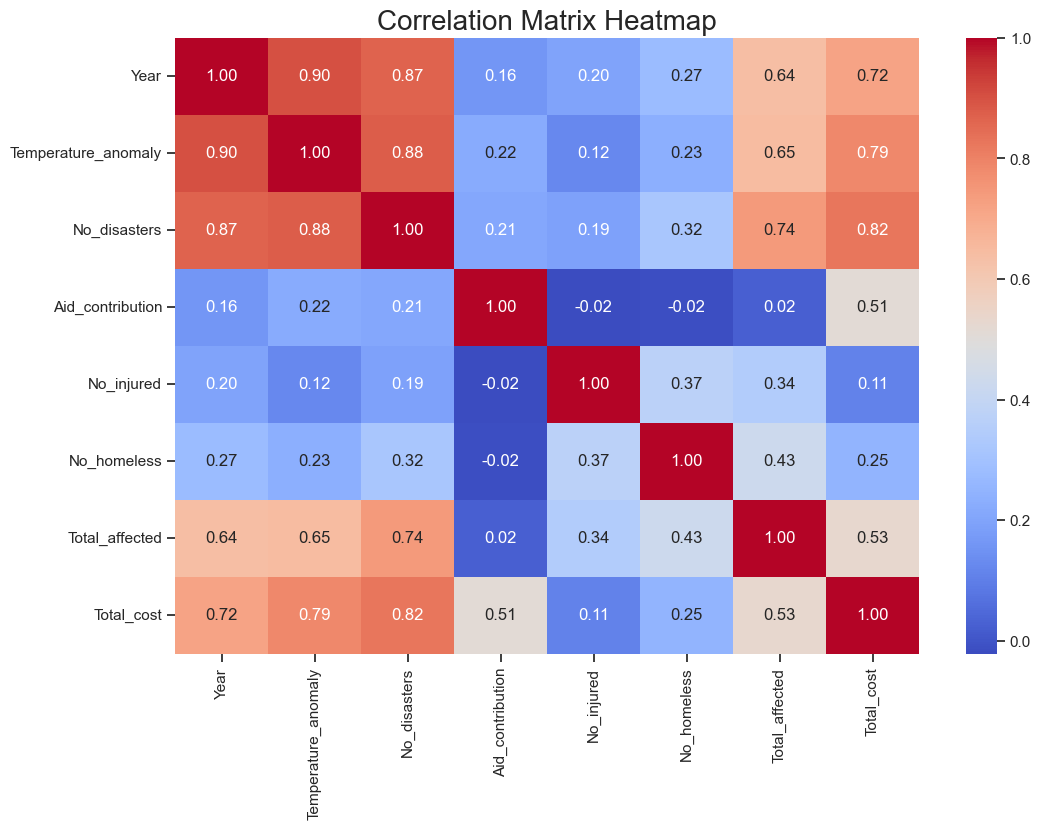

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix

numeric_data = year_df.select_dtypes(include=["number"])
correlation_matrix = numeric_data.corr()


# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,  # Annotate each cell with the correlation value
    fmt=".2f",   # Format to 2 decimal places
    cmap="coolwarm",  # Color map
    cbar=True     # Show color bar
)


# Add a title
plt.title("Correlation Matrix Heatmap", fontsize=20)
plt.show()

Split into training and test data:

In [121]:
target = "Total_cost"
disasters.data = year_df
X_train, X_test, y_train, y_test = disasters.split_train_test(target)

In [13]:
# Check the data types of X_train and X_test
print("Data types of X_train columns:")
print(X_train.dtypes)
print()

print("Data types of X_test columns:")
print(X_test.dtypes)

Data types of X_train columns:
Year                     int64
Temperature_anomaly    float64
No_disasters             int64
Aid_contribution       float64
No_injured             float64
No_homeless            float64
Total_affected         float64
dtype: object

Data types of X_test columns:
Year                     int64
Temperature_anomaly    float64
No_disasters             int64
Aid_contribution       float64
No_injured             float64
No_homeless            float64
Total_affected         float64
dtype: object


Scale the data:

In [122]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train, y_train, X_test, y_test = disasters.scale(scaler)

Create tensors:

In [123]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Create model:

In [124]:
# Define the model
model = nn.Sequential(
    nn.Linear(7, 13),
    nn.ReLU(),
    nn.Linear(13, 10),
    nn.ReLU(),
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimiser = optim.Adam(model.parameters(), lr=0.001)

Train model:

In [125]:
#From https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
import numpy as np
import torch
import tqdm
import copy

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train_tensor), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimiser.zero_grad()
            loss.backward()
            # update weights
            optimiser.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_tensor)
    mse = loss_fn(y_pred, y_test_tensor)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

Some graphs to show results:

MSE: 0.15
RMSE: 0.39


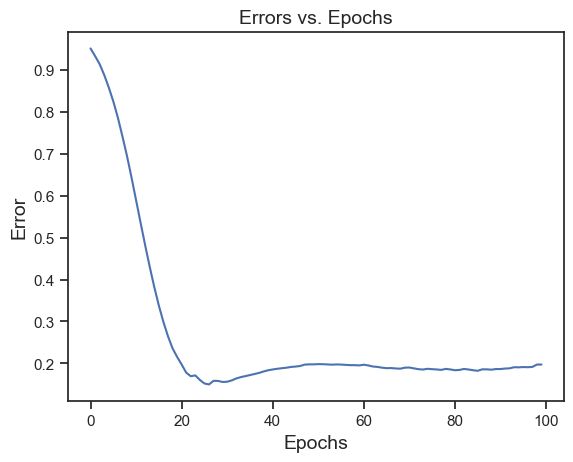

In [126]:
fontsize = 14

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.title("Errors vs. Epochs", fontsize=fontsize)
plt.xlabel("Epochs", fontsize=fontsize)
plt.ylabel("Error", fontsize=fontsize)
plt.plot(history)
plt.show()

Mean Squared Error on Test Data: 0.14994199573993683
R-squared on Test Data: 0.8500580191612244
RMSE: 0.3872234442023582


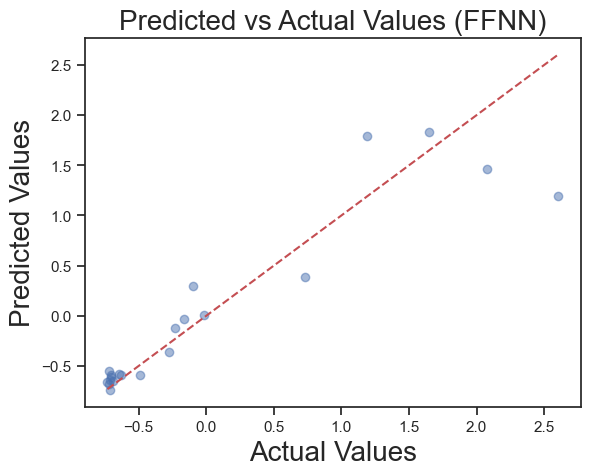

In [127]:
import math

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    y_test_pred = model(X_test_tensor)

mse = loss_fn(y_test_pred, y_test_tensor)
print(f"Mean Squared Error on Test Data: {mse.item()}")

ss_total = torch.sum((y_test_tensor - torch.mean(y_test_tensor))**2)
ss_residual = torch.sum((y_test_tensor - y_test_pred)**2)
r_squared = 1 - (ss_residual / ss_total)
print(f"R-squared on Test Data: {r_squared.item()}")
print(f"RMSE: {math.sqrt(mse.item())}")

import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
y_test_actual = y_test_tensor.numpy()
y_test_pred_np = y_test_pred.numpy()

fontsize = 20
plt.scatter(y_test_actual, y_test_pred_np, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Values", fontsize=fontsize)
plt.ylabel("Predicted Values", fontsize=fontsize)
plt.title("Predicted vs Actual Values (FFNN)", fontsize=fontsize)
plt.show()

Sort and descale data to get a comparison between predictions and actual:

In [128]:
from sklearn.preprocessing import StandardScaler

y_pred = torch.tensor(y_pred)

# Rescale the predictions back to the original scale
y_pred_numpy = y_pred.cpu().detach().numpy()
descaled_predictions = scaler.inverse_transform(y_pred_numpy.reshape(-1, 1))

/var/folders/16/vv67yqq12653l08qz2zn9sd80000gn/T/ipykernel_27343/2892140194.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(y_pred)


In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

x_values = disasters.X_test["Year"].values
y_values_test = disasters.y_test.values
y_values_pred = descaled_predictions.reshape(-1)

test = []
pred = []
for i, value in enumerate(x_values):
    pred.append((value, y_values_pred[i]))
    test.append((value, y_values_test[i]))

test.sort(key=lambda x: x[0])
pred.sort(key=lambda x: x[0])

x_values = [item[0] for item in test]
y_values_test = [item[1] for item in test]
y_values_pred = [item[1] for item in pred]

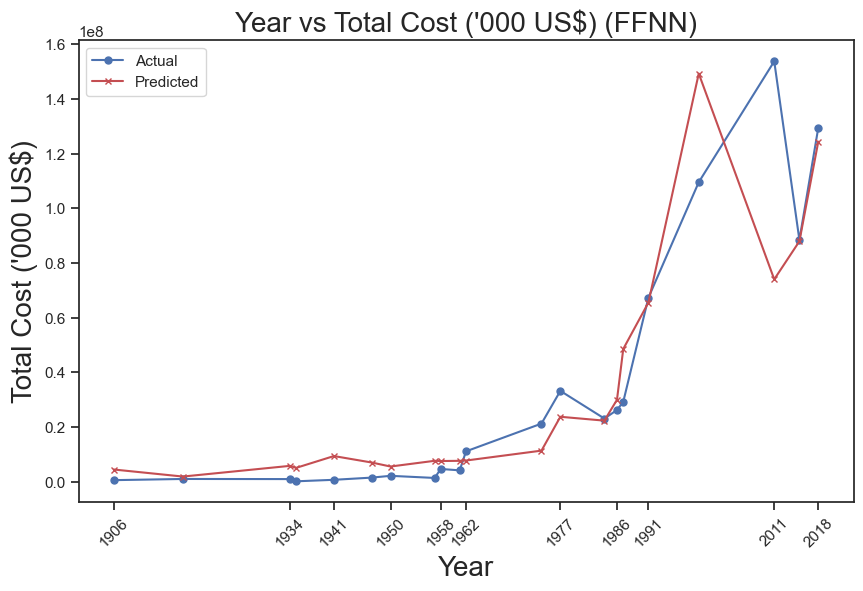

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

fontsize = 20

# Initialize the plot
plt.figure(figsize=(10, 6))
sns.set_theme(style="ticks", font_scale=1)

# Plot the actual data (y_values_test) vs years
plt.plot(x_values, y_values_test, label="Actual", color="b", marker="o", linestyle='-', markersize=5)

# Plot the predicted data (y_values_pred) vs years
plt.plot(x_values, y_values_pred, label="Predicted", color="r", linestyle='-', marker="x", markersize=5)

# Set labels and title
plt.xlabel("Year", fontsize=fontsize)
plt.ylabel("Total Cost ('000 US$)", fontsize=fontsize)
plt.title("Year vs Total Cost (\'000 US$) (FFNN)", fontsize=fontsize)

plt.legend()

plt.xticks(x_values[::2], rotation=45)

plt.show()

# Exploration of XGBoost on Climate Data

In [131]:
disasters.data.head()

,Year,Temperature_anomaly,No_disasters,Aid_contribution,No_injured,No_homeless,Total_affected,Total_cost
0,1900,-0.08,1,0.0,0.0,0.0,0.0,9.312006e+05
1,1903,-0.37,1,0.0,0.0,0.0,0.0,1.379557e+07
2,1906,-0.23,1,0.0,0.0,0.0,0.0,5.748152e+05
3,1911,-0.44,1,0.0,0.0,0.0,0.0,5.542861e+05
4,1912,-0.36,3,0.0,200.0,2500.0,2700.0,9.365524e+05


In [132]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

df = disasters.data

X = df.drop(columns=['Total_cost'])  # Features
y = df['Total_cost']  # Target

Scale the data:

In [133]:
X_train, X_test, y_train, y_test = disasters.split_train_test('Total_cost')

scaler = StandardScaler()
X_train, y_train, X_test, y_test = disasters.scale(scaler)


In [134]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evals_result = {}

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 3,
    'colsample_bytree': 0.9,
    'subsample': 0.8,
    'gamma': 0,
    'min_child_weight': 10,
    'booster': 'gbtree'
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=50,
    evals_result = evals_result,
    verbose_eval=False
)

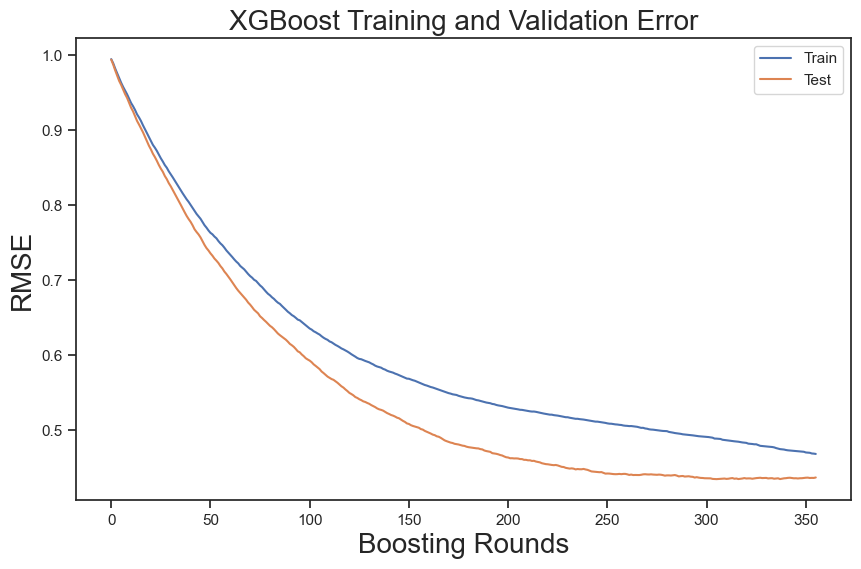

In [135]:
# Plot the error for each dataset
epochs = len(evals_result['train']['rmse'])  # Replace 'rmse' with the metric used
x_axis = range(epochs)

fontsize=20
plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['rmse'], label='Train')
plt.plot(x_axis, evals_result['test']['rmse'], label='Test')
plt.legend()
plt.xlabel('Boosting Rounds', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.title('XGBoost Training and Validation Error', fontsize=fontsize)
plt.show()

In [136]:
from sklearn.metrics import mean_squared_error, r2_score
import math

# Make predictions
y_pred = model.predict(dtest)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f"RMSE: {math.sqrt(mse)}")
print(f'R-squared: {r2}')


Mean Squared Error: 0.19090967741848489
RMSE: 0.4369321199208006
R-squared: 0.8090903225815151


A quick test with k-fold cross validation to see if there is any improvement:

In [137]:
import xgboost as xgb
import pandas as pd

# Create the DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 8,
    'colsample_bytree': 0.9,
    'subsample': 0.8,
    'gamma': 0,
    'min_child_weight': 10,
    'booster': 'gbtree'
}

# Perform k-fold cross-validation
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    nfold=5,  # Number of folds
    metrics='rmse',  # Metric to evaluate
    early_stopping_rounds=50,  # Stop early if no improvement
    seed=42
)

# Print the best boosting round and results
print(f"Optimal Boost Rounds: {len(cv_results)}")
print(cv_results.tail())

optimal_boost_rounds = len(cv_results)
print(f"Optimal Boost Rounds: {optimal_boost_rounds}")


Optimal Boost Rounds: 21
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
16         0.536944        0.123052        0.542424       0.448523
17         0.531584        0.121697        0.542139       0.450809
18         0.525033        0.121028        0.539007       0.449774
19         0.519023        0.120542        0.538316       0.445808
20         0.516214        0.120323        0.533879       0.443434
Optimal Boost Rounds: 21


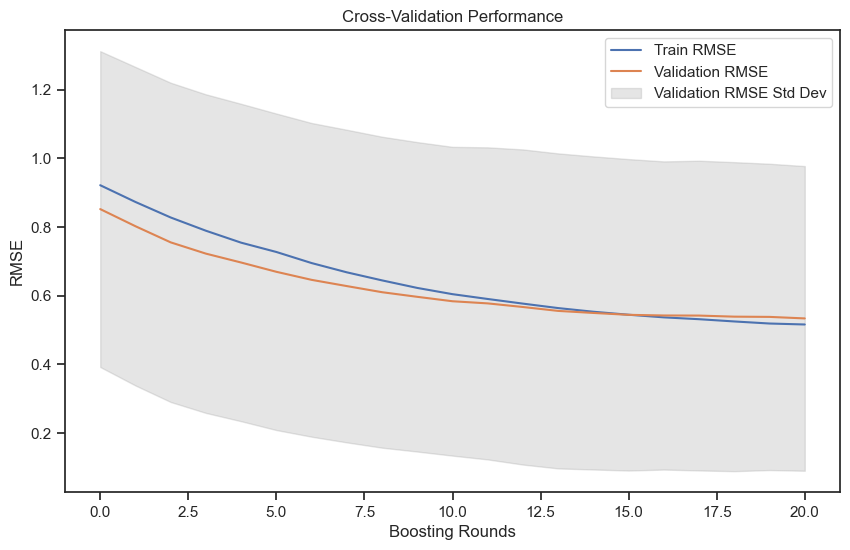

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cv_results['train-rmse-mean'], label='Train RMSE')
plt.plot(cv_results['test-rmse-mean'], label='Validation RMSE')
plt.fill_between(
    range(len(cv_results)),
    cv_results['test-rmse-mean'] - cv_results['test-rmse-std'],
    cv_results['test-rmse-mean'] + cv_results['test-rmse-std'],
    color='gray', alpha=0.2, label='Validation RMSE Std Dev'
)
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Cross-Validation Performance')
plt.legend()
plt.show()


In [139]:
final_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=optimal_boost_rounds
)


In [140]:
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = final_model.predict(dtest)

from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse}")
print(f"Test R2: {r2}")


Test RMSE: 0.44508077534104057
Test R2: 0.8019031034218183


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


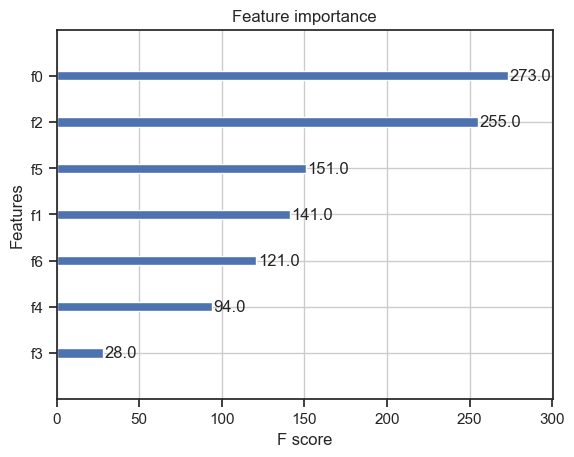

In [141]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plot_importance(model)
plt.show()


## Try a grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.005, 0.01, 0.1],
    'gamma': [0, 1, 5],
    'colsample_bytree': [0.7, 0.9],
    'min_child_wheight': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3
)

grid_search.fit(X_train, y_train)

# Use the best estimator
best_model = grid_search.best_estimator_


In [57]:
# Best parameters
print(grid_search.best_params_)

{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_wheight': 2, 'n_estimators': 500}


Use best model from GridSearch if wanted:

In [58]:
final_model = best_model

In [144]:
# Make predictions
y_pred = final_model.predict(dtest)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.1980968965781818
R-squared: 0.8019031034218183


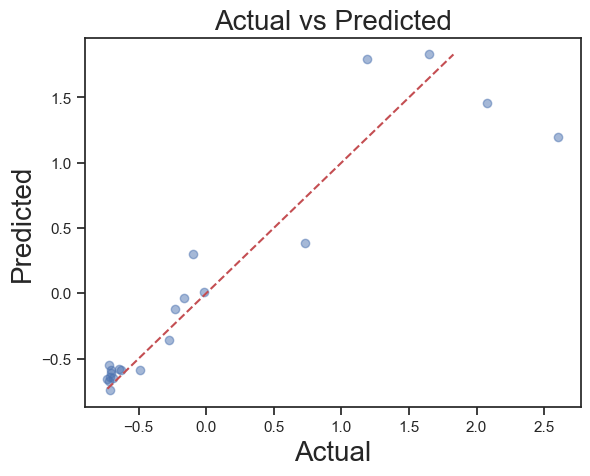

In [145]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
y_test_actual = y_test_tensor.numpy()
y_pred_np = y_test_pred.numpy()

fontsize=20
plt.scatter(y_test_actual, y_pred_np, alpha=0.5)
plt.plot([y_test_actual.min(), y_pred_np.max()], [y_test_actual.min(), y_pred_np.max()], 'r--')
plt.xlabel('Actual', fontsize=fontsize)
plt.ylabel('Predicted', fontsize=fontsize)
plt.title('Actual vs Predicted', fontsize=fontsize)
plt.show()


Plot predictions and actual data for total costs:

In [146]:
disasters.data.head()

,Year,Temperature_anomaly,No_disasters,Aid_contribution,No_injured,No_homeless,Total_affected,Total_cost
0,1900,-0.08,1,0.0,0.0,0.0,0.0,9.312006e+05
1,1903,-0.37,1,0.0,0.0,0.0,0.0,1.379557e+07
2,1906,-0.23,1,0.0,0.0,0.0,0.0,5.748152e+05
3,1911,-0.44,1,0.0,0.0,0.0,0.0,5.542861e+05
4,1912,-0.36,3,0.0,200.0,2500.0,2700.0,9.365524e+05


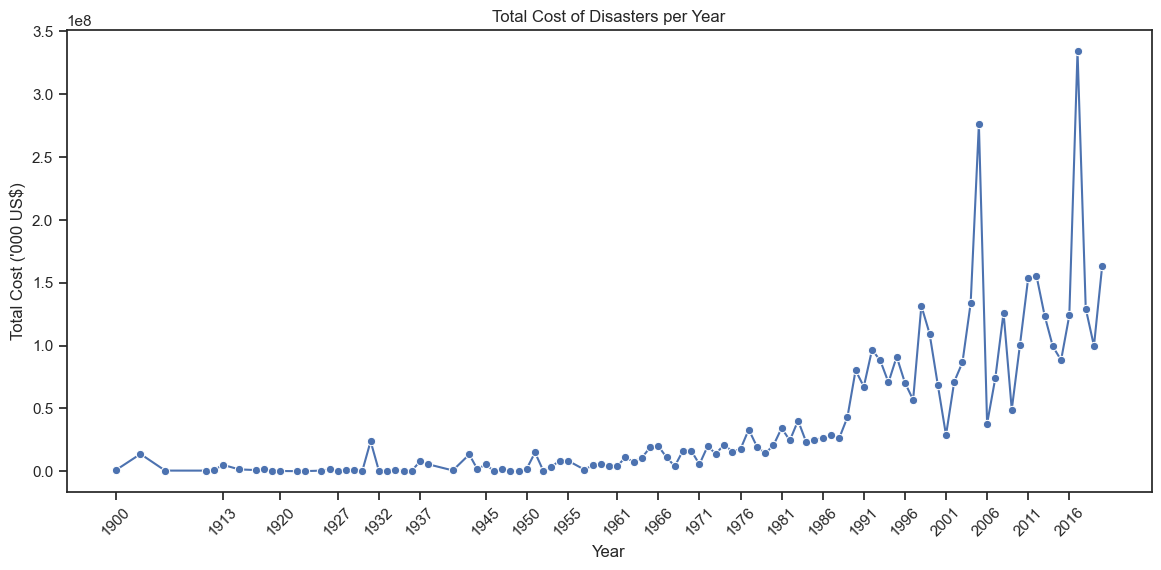

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cost_by_year(df, year_column, cost_column, title, x_label="Year", y_label="Total Cost ('000 US$)", figsize=(14, 6)):

    # Aggregate the total cost of disasters per year
    cost_by_year = df.groupby(year_column)[cost_column].sum()
    
    # Initialize the figure
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)

    # Plot the total cost by year
    ax = sns.lineplot(x=cost_by_year.index, y=cost_by_year.values, marker="o", color="b")
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    ax.set_xticks(cost_by_year.index[::5])
    plt.xticks(rotation=45)
    plt.show()

plot_cost_by_year(
    df=disasters.data,        
    year_column="Year",     
    cost_column="Total_cost",
    title="Total Cost of Disasters per Year"
)


In order to plot the predicted values vs actual, the predicted values must be descaled, using the same scaler I used to scale in the first place:

In [148]:
from sklearn.preprocessing import StandardScaler

y_pred = torch.tensor(y_pred)

# Rescale the predictions back to the original scale
y_pred_numpy = y_pred.cpu().detach().numpy()
descaled_predictions = scaler.inverse_transform(y_pred_numpy.reshape(-1, 1))

Then the values must be sorted by year to get a lined graph that makes sense:

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

x_values = disasters.X_test["Year"].values
y_values_test = disasters.y_test.values
y_values_pred = descaled_predictions.reshape(-1)

test = []
pred = []
for i, value in enumerate(x_values):
    pred.append((value, y_values_pred[i]))
    test.append((value, y_values_test[i]))

test.sort(key=lambda x: x[0])
pred.sort(key=lambda x: x[0])

x_values = [item[0] for item in test]
y_values_test = [item[1] for item in test]
y_values_pred = [item[1] for item in pred]

In [150]:
print(y_values_pred)

[8770202.0, 8770202.0, 8770202.0, 8770202.0, 11211874.0, 10389516.0, 8770202.0, 11530420.0, 11530420.0, 11530420.0, 11170986.0, 20059980.0, 19999224.0, 25957442.0, 32048648.0, 29046816.0, 45927000.0, 76206790.0, 83226910.0, 103895730.0, 96031780.0]


Finally, the plot of how the FFNN-model performed compared to the actual test data:

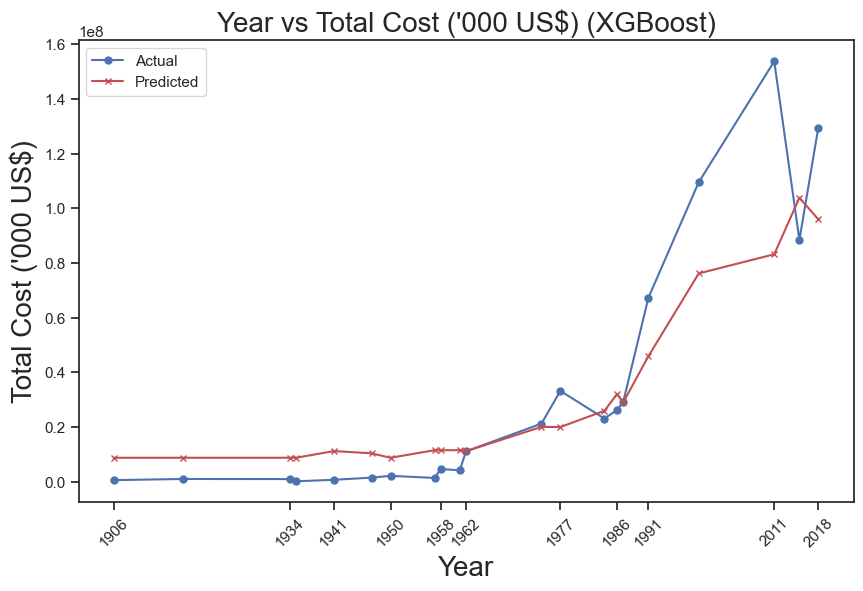

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

fontsize = 20

# Initialize the plot
plt.figure(figsize=(10, 6))
sns.set_theme(style="ticks", font_scale=1)

# Plot the actual data (y_values_test) vs years
plt.plot(x_values, y_values_test, label="Actual", color="b", marker="o", linestyle='-', markersize=5)

# Plot the predicted data (y_values_pred) vs years
plt.plot(x_values, y_values_pred, label="Predicted", color="r", linestyle='-', marker="x", markersize=5)

# Set labels and title
plt.xlabel("Year", fontsize=fontsize)
plt.ylabel("Total Cost ('000 US$)", fontsize=fontsize)
plt.title("Year vs Total Cost (\'000 US$) (XGBoost)", fontsize=fontsize)

plt.legend()

plt.xticks(x_values[::2], rotation=45)

plt.show()